In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from dataclasses import dataclass, field

In [2]:
import sklearn; sklearn.__version__

'0.20.1'

In [3]:
np.random.seed(123)

In [4]:
class Hyperplane:
    def __init__(self, v:np.ndarray, x_range=[-8,8], label=None, color='black', alpha=1.0):
        self.v = v
        self.x = np.linspace(x_range[0], x_range[1])
        self.y = self.hyperplane_y(self.x, self.v)
        self.label, self.color, self.alpha = label, color, alpha
    
    @staticmethod
    def hyperplane_y(hyperplane_x, w): 
        """
        Given a vector of x-coordinates, return the vector of y-coordinates
        that correspond to the hyperplan defined by w
        """
        return (-hyperplane_x*w[0]) / w[1]

    def plot(self, ax):
        ax.plot(self.x, self.y, color=self.color, label=self.label, alpha=self.alpha)
        return ax
    
@dataclass
class PointCloud:
    df: pd.DataFrame
    class_0_color: str = 'tab:blue'
    class_0_name: str = 'Class 0'
    class_1_color: str = 'tab:orange'
    class_1_name: str = 'Class 1'
    alpha: float = 1.0
    
    def plot(self, ax):
        ax.scatter(df.query('y==0')['x1'], df.query('y==0')['x2'], color=self.class_0_color, 
                   label=self.class_0_name, alpha=self.alpha)
        ax.scatter(df.query('y==1')['x1'], df.query('y==1')['x2'], color=self.class_1_color,
                   label=self.class_1_name, alpha=self.alpha)
        return ax
    
@dataclass
class ExtraPoint:
    x: np.ndarray
    color: str = 'black'
    label: str = None
    size: int = 20
    alpha: float = 1.0
        
    def plot(self, ax):
        ax.scatter(self.x[0], self.x[1], color=self.color, label=self.label, s=self.size,
                   alpha=self.alpha)
        return ax
    
@dataclass
class Vector:
    v: np.ndarray
    color: str = 'black'
    label: str = None
    alpha: float = 1.0
    label_offset: tuple = (.005, .005)
    label_fontsize: int = 18
        
    def plot(self, ax):
        ax.quiver(0,0, self.v[0], self.v[1], scale_units='xy', scale=1, color=self.color,
                  label=self.label, alpha=self.alpha)
        if self.label is not None:
            ax.text(self.v[0]+self.label_offset[0], self.v[1]+self.label_offset[1], self.label,
                    fontsize=self.label_fontsize, color=self.color, alpha=self.alpha)
        return ax

In [5]:
def plot_state(draw_objs, xlim=(-5,5), ylim=(-5,5), figsize=(8,8), grid=False, legend=False, title=None):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_aspect('equal')

    for obj in draw_objs:
        ax = obj.plot(ax)

    ax.set_xlim(*xlim); ax.set_ylim(*ylim)
    if grid: ax.grid()
    if legend: ax.legend()
    ax.set_title(title)
    plt.show()
    return ax

In [6]:
def sigmoid(x): return 1/(1+np.exp(-x))

In [7]:
def lr_predict_proba(w, x):
    return sigmoid(float(w.T @ x))

In [8]:
draw_objs = []

## generate data

In [9]:
n0 = 100; n1 = 100; var=0.7
c0 = np.random.multivariate_normal([-2.5,-2.5], [[var,0],[0,var]], n0)
c1 = np.random.multivariate_normal([2.5,2.5], [[var,0],[0,var]], n1)
df = pd.DataFrame(np.concatenate([c0, c1], axis=0), columns=['x1', 'x2'])
df['y'] = [0]*n0 + [1]*n1
print(df.shape)
df.head()

(200, 3)


,x1,x2,y
0,-3.408304,-1.665561,0
1,-2.263243,-3.760257,0
2,-2.984092,-1.118309,0
3,-4.530306,-2.858854,0
4,-1.440842,-3.225167,0


In [10]:
pc = PointCloud(df)
draw_objs.append(pc)

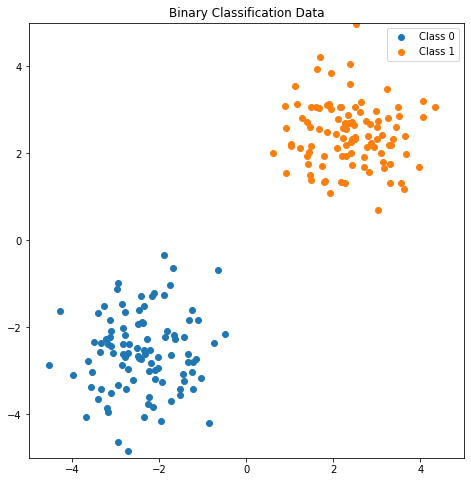

In [11]:
_ = plot_state(draw_objs, legend=True, title='Binary Classification Data')

## fit decision boundary

In [12]:
# lr = LogisticRegression(fit_intercept=False, solver='lbfgs')
# lr.fit(X=df[['x1', 'x2']], y=df['y'])

In [13]:
# lr.coef_, lr.intercept_

In [14]:
# w = Vector(v=lr.coef_.reshape(-1,1), color='black', label='w')
# w

In [15]:
w = Vector(v=np.array([1., 1.]).reshape(-1,1), color='black', label='w', label_offset=[0.01, -.2])
draw_objs.append(w)

## create decision boundary hyperplane

In [16]:
db = Hyperplane(w.v, label='Decision Boundary', color='black')
draw_objs.append(db)

In [17]:
pc.alpha = 0.5

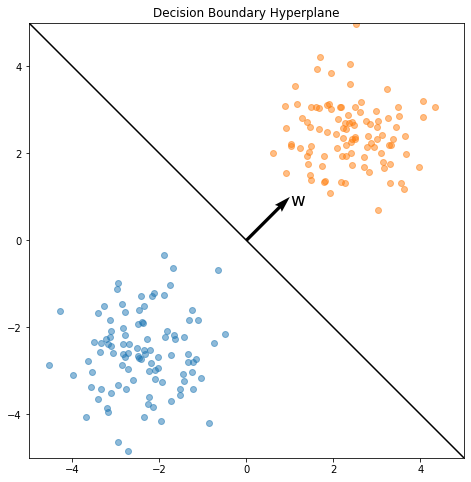

In [18]:
_ = plot_state(draw_objs, title='Decision Boundary Hyperplane')

## add incorrectly classified point

In [19]:
x = ExtraPoint(x=np.array([-3, 1]).reshape(-1,1), color='tab:orange', label='Class 1', size=100)
draw_objs.append(x)
x

ExtraPoint(x=array([[-3],
       [ 1]]), color='tab:orange', label='Class 1', size=100, alpha=1.0)

In [20]:
w.alpha = 0.5
db.alpha = 0.5

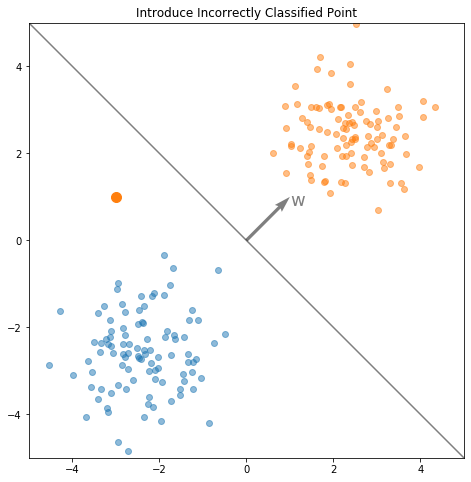

In [21]:
_ = plot_state(draw_objs, title='Introduce Incorrectly Classified Point')

## compute gradient wrt that point

In [22]:
sigma = lr_predict_proba(w.v, x.x)
sigma

0.11920292202211755

In [23]:
y = 1

In [24]:
grad = (y-sigma) * x.x
grad = Vector(v=grad, color='red', label='gradient', label_offset=[-1.4, -.6])
draw_objs.append(grad)
grad

Vector(v=array([[-2.64239123],
       [ 0.88079708]]), color='red', label='gradient', alpha=1.0, label_offset=[-1.4, -0.6], label_fontsize=18)

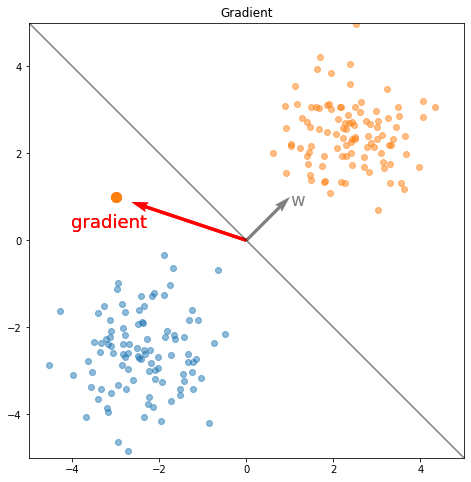

In [25]:
draw_objs.extend([x, grad])
_ = plot_state(draw_objs, title='Gradient')

## update w

In [26]:
lr = 1e-1
w_update = lr * grad.v

In [27]:
w_update

array([[-0.26423912],
       [ 0.08807971]])

In [28]:
w.v

array([[1.],
       [1.]])

In [29]:
w_update

array([[-0.26423912],
       [ 0.08807971]])

In [30]:
w_new = w.v + w_update
w_new = Vector(w_new, color='black', label="w'", label_offset=[-.5, -.0])
draw_objs.append(w_new)

In [31]:
w_new

Vector(v=array([[0.73576088],
       [1.08807971]]), color='black', label="w'", alpha=1.0, label_offset=[-0.5, -0.0], label_fontsize=18)

In [32]:
db_new = Hyperplane(v=w_new.v)
draw_objs.append(db_new)

In [33]:
db.alpha = 0.3
w.alpha = 0.3
w.label = None
grad.label = None
grad.alpha = 0.2
x.alpha = 0.5

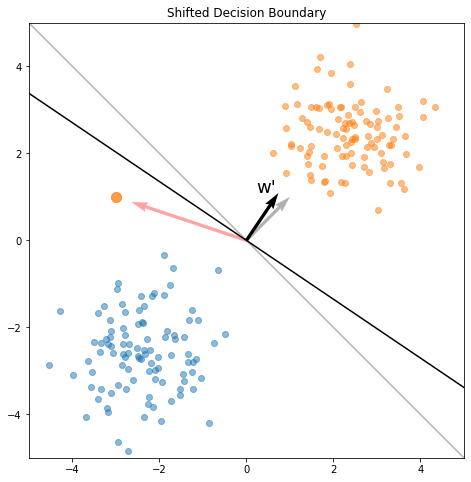

In [34]:
_ = plot_state(draw_objs, title='Shifted Decision Boundary')